## Brain tumor Classification - VGG16 architecture

### Step№1: Import libraries

In [1]:

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.utils import to_categorical
from keras.applications import VGG16, Xception
from tensorflow.keras.layers import (Input, 
                                     Add, 
                                     Dense, 
                                     Activation, 
                                     BatchNormalization, 
                                     Flatten, 
                                     Conv2D, 
                                     AveragePooling2D, 
                                     MaxPooling2D, 
                                     GlobalAveragePooling2D,
                                     Dropout)

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.callbacks import (ReduceLROnPlateau, 
                                        EarlyStopping, 
                                        ModelCheckpoint, 
                                        LearningRateScheduler)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import os
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# Visualizing plot of train and validation loss &  accuracy
def plot_history_acc_loss(history):
    epochs = range(len(history.history['loss']))
    fig, ax = plt.subplots(1,2,figsize=(10,7))
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    
    sns.despine()
    ax[0].plot(epochs, train_acc, color= 'red',
               label = 'Training Accuracy')
    ax[0].plot(epochs, val_acc, color= 'green',
               label = 'Validation Accuracy')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    sns.despine()
    ax[1].plot(epochs, train_loss, color='red',
               label ='Training Loss')
    ax[1].plot(epochs, val_loss, color='green',
               label = 'Validation Loss')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Loss')

    fig.show()

### Step№2: Importing dataset

In [7]:
Brain_directory = ('../archive/Training/')
test_directory = ('../archive/Testing/')

In [8]:
classes = os.listdir(Brain_directory)
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [9]:
for idx, name in enumerate(classes):
    print(f"{idx} = {name}", end=", ")

0 = glioma_tumor, 1 = meningioma_tumor, 2 = no_tumor, 3 = pituitary_tumor, 

### Step№3 Data Augmentation

In [10]:
#resize images and convert to numpy.
IMAGE = []
LABELS = []
image_size = 224
for label in classes:
    path_train = os.path.join(Brain_directory, label)
    for j in os.listdir(path_train):
        img = cv2.imread(os.path.join(path_train, j))
        img = cv2.resize(img,(image_size,image_size))
        IMAGE.append(img)
        LABELS.append(label)
            
        
for label in classes:
    path_test = os.path.join(test_directory, label)
    for j in os.listdir(path_test):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        IMAGE.append(img)
        LABELS.append(label)
        
X = np.array(IMAGE)
y = np.array(LABELS)

In [11]:
classes_info = {}
classes = sorted(os.listdir(Brain_directory))
for name in classes:
    classes_info[name] = len(os.listdir(Brain_directory + f'/{name}'))
print(classes_info)
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05,title= 'Training dataset')
fig.update_layout({'title':{"x":0.1}})
fig.show()


{'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395, 'pituitary_tumor': 827}


In the training dataset:

    3 = pituitary_tumor 827(28.8%). 
    0 = glioma_tumor 826(28.8%), 
    1 = meningioma_tumor 822(28.6%), 
    2 = no_tumor 395(13.8%).

In [21]:
classes_info = {}
classes = sorted(os.listdir(test_directory))
for name in classes:
    classes_info[name] = len(os.listdir(test_directory + f'/{name}'))
print(classes_info)
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05,title='Testing dataset')
fig.update_layout({'title':{"x":0.1}})
fig.show()

{'glioma_tumor': 100, 'meningioma_tumor': 115, 'no_tumor': 105, 'pituitary_tumor': 74}


In the testing dataset:

    1 = meningioma_tumor 115(29.2%), 
    2 = no_tumor 105(26.6%),
    0 = glioma_tumor 100(25.4%), 
    3 = pituitary_tumor 74(18.8%)

### Split dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((2611, 224, 224, 3), (653, 224, 224, 3))

In [13]:
X_train, y_train = shuffle(X_train, y_train, random_state= 0)

### to_categorical

In [14]:
y_train_new = []
for i in y_train:
    y_train_new.append(classes.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(classes.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

### Step№4 Data Generator

In [15]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [16]:
train_generator = image_generator.flow_from_directory(
    batch_size = 40,
    directory = Brain_directory,
    shuffle = True, 
    target_size = (224, 224),
    class_mode = 'categorical',
    subset = 'training'
)

Found 2297 images belonging to 4 classes.


In [17]:
validation_generator = image_generator.flow_from_directory(
    batch_size = 40, 
    directory = Brain_directory,
    shuffle = True, 
    target_size = (224, 224),
    class_mode = 'categorical',
    subset = 'validation'
)

Found 573 images belonging to 4 classes.


In [18]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(
    batch_size = 4, 
    directory = test_directory, 
    shuffle = True, 
    target_size = (224, 224), 
    class_mode = 'categorical'
)

Found 394 images belonging to 4 classes.


In [19]:
print(test_generator.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [20]:
train_images, train_labels = next(train_generator)
train_images.shape

(40, 224, 224, 3)

### Step№5 Showing images

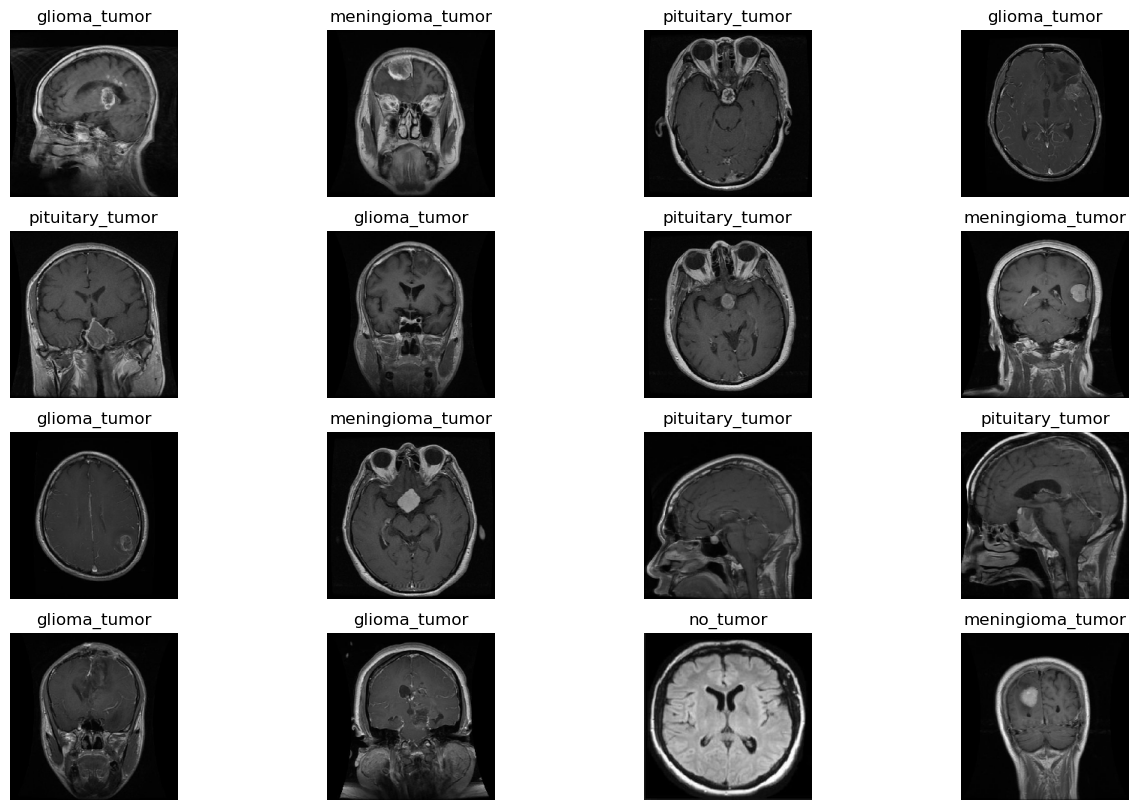

In [22]:
L = 4 
W = 4

fig, axes = plt.subplots(L, W, figsize = (15, 10))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(classes[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

## I. Step№6 Transfer learning - VGG16

   A VGG network consists of small convolution filters. VGG16 has three fully connected layers and 13 convolutional layers.

Here is a quick outline of the VGG architecture:

  1. Input—VGGNet receives a 224×224 image input. In the ImageNet competition, the model’s creators kept the image input size constant by cropping a 224×224 section from the center of each image.
  2. Convolutional layers—the convolutional filters of VGG use the smallest possible receptive field of 3×3. VGG also uses a 1×1 convolution filter as the input’s linear transformation. 
  3. ReLu activation—next is the Rectified Linear Unit Activation Function (ReLU) component, AlexNet’s major innovation for reducing training time. ReLU is a linear function that provides a matching output for positive inputs and outputs zero for negative inputs. VGG has a set convolution stride of 1 pixel to preserve the spatial resolution after convolution (the stride value reflects how many pixels the filter “moves” to cover the entire space of the image).
  4. Hidden layers—all the VGG network’s hidden layers use ReLU instead of Local Response Normalization like AlexNet. The latter increases training time and memory consumption with little improvement to overall accuracy.
  5. Pooling layers–A pooling layer follows several convolutional layers—this helps reduce the dimensionality and the number of parameters of the feature maps created by each convolution step. Pooling is crucial given the rapid growth of the number of available filters from 64 to 128, 256, and eventually 512 in the final layers.
  6. Fully connected layers—VGGNet includes three fully connected layers. The first two layers each have 4096 channels, and the third layer has 1000 channels, one for every class.
  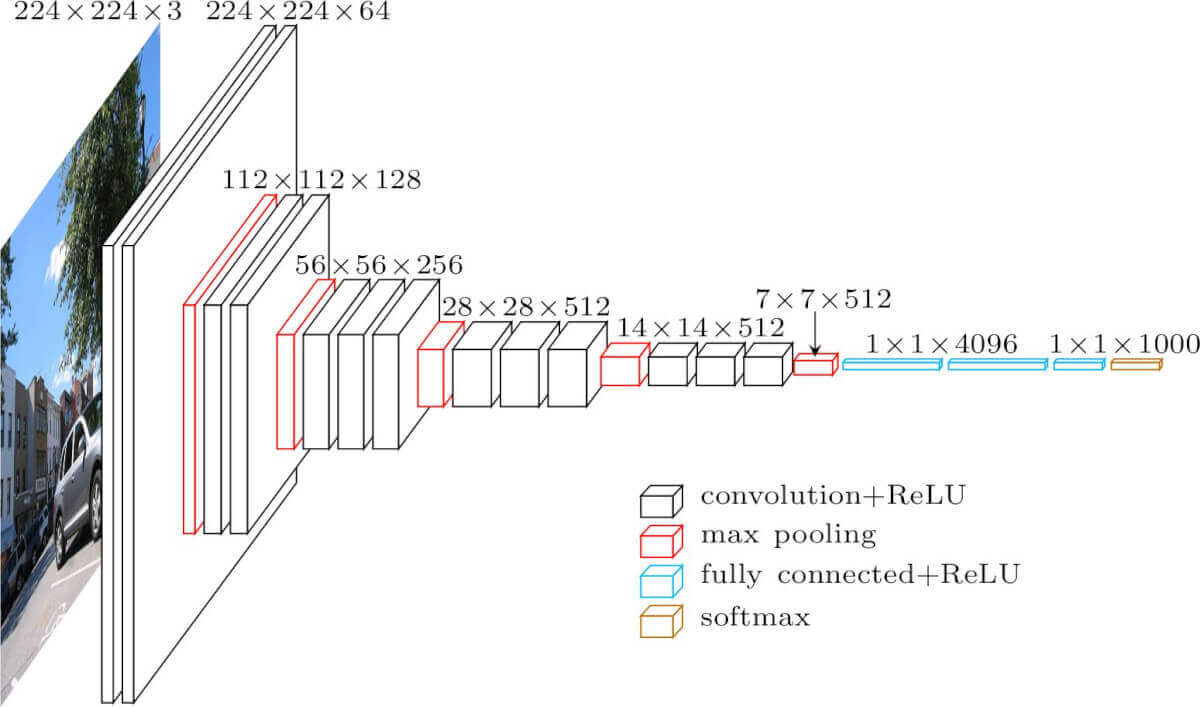

In [23]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

checkpointer = ModelCheckpoint(filepath= 'brain2weights.hdf5', verbose = 1, save_best_only = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5,patience = 2, mode = 'auto', min_lr = 1e-15)
                             

In [24]:
train_generator = image_generator.flow_from_directory(
    batch_size = 4,
    directory = Brain_directory,
    shuffle = True, 
    target_size = (224, 224),
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = image_generator.flow_from_directory(
    batch_size = 4, 
    directory = Brain_directory,
    shuffle = True, 
    target_size = (224, 224),
    class_mode = 'categorical',
    subset = 'validation'
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [ ]:
y_test

In [25]:
base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [26]:
for layer in base_model.layers:
    layer.trainable = False

In [27]:
base_model.summary() 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Step№7 Train model  

### One hidden layer

In [28]:
model_vgg16 = base_model.output
model_vgg16 = MaxPooling2D()(model_vgg16)
model_vgg16 = Dropout(0.3)(model_vgg16)
model_vgg16 = Flatten(name = 'flatten')(model_vgg16)
model_vgg16 = Dense(1000, activation = 'relu')(model_vgg16)
model_vgg16 = Dropout(0.3)(model_vgg16)
model_vgg16 = Dense(4, activation = 'softmax')(model_vgg16)


model_2 = Model(inputs = base_model.input, outputs = model_vgg16)

In [29]:
model_2.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-3), metrics= ['accuracy'])

In [30]:
history = model_2.fit(X_train, y_train,
    epochs = 50, 
    validation_data = (X_test, y_test), 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/50
82/82 [==============================] - ETA: 0s - loss: 13.5732 - accuracy: 0.6925
Epoch 1: val_loss improved from inf to 1.17939, saving model to brain2weights.hdf5
82/82 [==============================] - 18s 125ms/step - loss: 13.5732 - accuracy: 0.6925 - val_loss: 1.1794 - val_accuracy: 0.8361
Epoch 2/50
81/82 [============================>.] - ETA: 0s - loss: 0.9353 - accuracy: 0.8310
Epoch 2: val_loss improved from 1.17939 to 0.44051, saving model to brain2weights.hdf5
82/82 [==============================] - 7s 82ms/step - loss: 0.9303 - accuracy: 0.8315 - val_loss: 0.4405 - val_accuracy: 0.8499
Epoch 3/50
81/82 [============================>.] - ETA: 0s - loss: 0.4376 - accuracy: 0.8789
Epoch 3: val_loss improved from 0.44051 to 0.42220, saving model to brain2weights.hdf5
82/82 [==============================] - 7s 81ms/step - loss: 0.4350 - accuracy: 0.8794 - val_loss: 0.4222 - val_accuracy: 0.8821
Epoch 4/50
81/82 [============================>.] - ETA: 0s - loss:

C:\Users\User\AppData\Local\Temp\ipykernel_2380\178661625.py:29: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



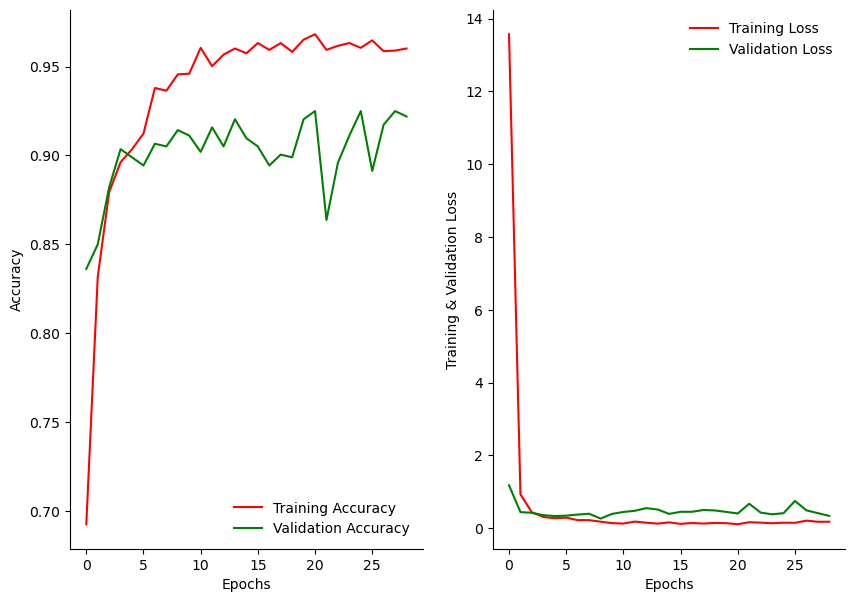

In [31]:
plot_history_acc_loss(history)

In [32]:
evaluate = model_2.evaluate(X_test, y_test)
print('Testing accuracy : {}'.format(evaluate[1])) 
print('Testing loss: {}'.format(evaluate[0]))

21/21 [==============================] - 2s 61ms/step - loss: 0.3368 - accuracy: 0.9219
Testing accuracy : 0.9218989014625549
Testing loss: 0.3368397057056427


In [33]:
test_predictions = model_2.predict(X_test)
pred = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, pred))

21/21 [==============================] - 2s 74ms/step
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       181
           1       0.92      0.86      0.89       200
           2       0.97      0.94      0.95        95
           3       0.94      0.97      0.96       177

    accuracy                           0.92       653
   macro avg       0.93      0.93      0.93       653
weighted avg       0.92      0.92      0.92       653



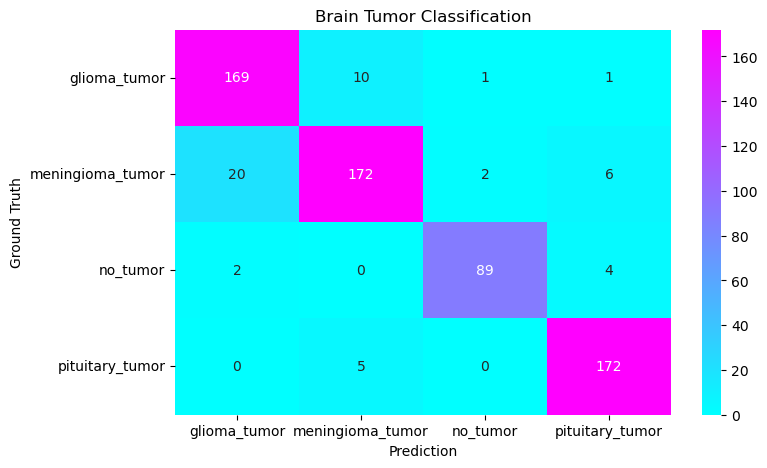

In [34]:
cm = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,5))
ax = sns.heatmap(cm, cmap='cool', annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes)
plt.title('Brain Tumor Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

    with one hidden layer shows good results above 86% : training - 96%, test - 92%.
    meningioma_tumor - 86% recall , 89% f1-score, glioma_tumor - 88% precision.

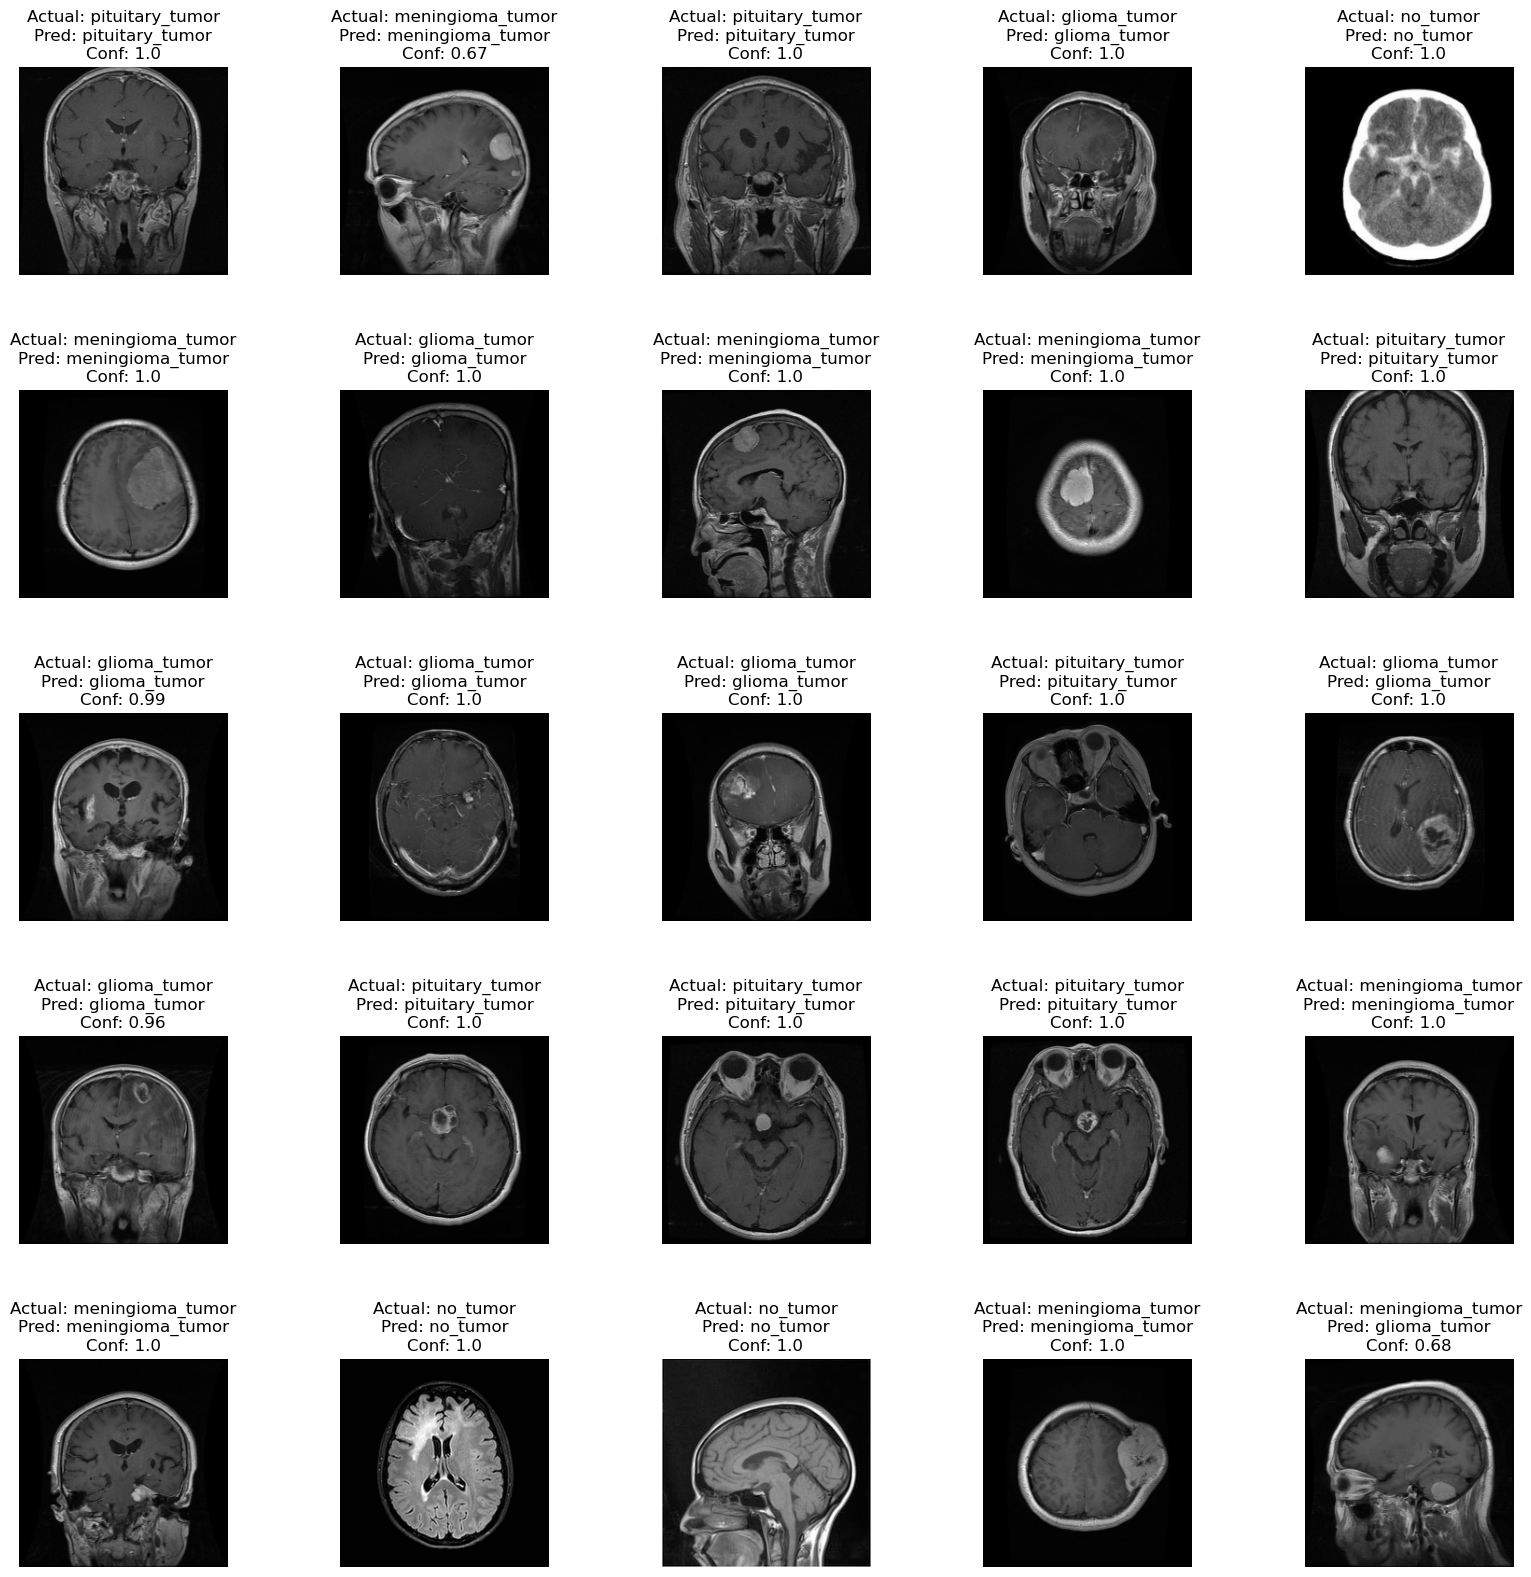

In [35]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = pred[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+classes[actual]+'\nPred: '+classes[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)   

    the VGG16 model predicts pretty well. But with one layer it gives an error for glioma and meningioma. 

### Two hidden layer

In [36]:
base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

In [37]:
model_vgg16 = base_model.output
model_vgg16 = MaxPooling2D()(model_vgg16)
model_vgg16 = Dropout(0.3)(model_vgg16)
model_vgg16 = Flatten(name = 'flatten')(model_vgg16)
model_vgg16 = Dense(4096, activation = 'relu')(model_vgg16)
model_vgg16 = Dropout(0.3)(model_vgg16)
model_vgg16 = Dense(1000, activation = 'relu')(model_vgg16)
model_vgg16 = Dropout(0.3)(model_vgg16)
model_vgg16 = Dense(4, activation = 'softmax')(model_vgg16)


model_2 = Model(inputs = base_model.input, outputs = model_vgg16)

In [38]:
model_2.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-3), metrics= ['accuracy'])

In [39]:
history = model_2.fit(X_train, y_train,
    epochs = 50, 
    validation_data = (X_test, y_test), 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/50
81/82 [============================>.] - ETA: 0s - loss: 17.3271 - accuracy: 0.5984
Epoch 1: val_loss did not improve from 0.26324
82/82 [==============================] - 7s 83ms/step - loss: 17.2088 - accuracy: 0.5982 - val_loss: 0.5769 - val_accuracy: 0.7749
Epoch 2/50
81/82 [============================>.] - ETA: 0s - loss: 0.6249 - accuracy: 0.7728
Epoch 2: val_loss did not improve from 0.26324
82/82 [==============================] - 7s 81ms/step - loss: 0.6242 - accuracy: 0.7733 - val_loss: 0.4230 - val_accuracy: 0.8499
Epoch 3/50
81/82 [============================>.] - ETA: 0s - loss: 0.4652 - accuracy: 0.8407
Epoch 3: val_loss did not improve from 0.26324
82/82 [==============================] - 7s 81ms/step - loss: 0.4662 - accuracy: 0.8407 - val_loss: 0.3758 - val_accuracy: 0.8652
Epoch 4/50
81/82 [============================>.] - ETA: 0s - loss: 0.3596 - accuracy: 0.8816
Epoch 4: val_loss did not improve from 0.26324
82/82 [==============================] - 7s 

C:\Users\User\AppData\Local\Temp\ipykernel_2380\178661625.py:29: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



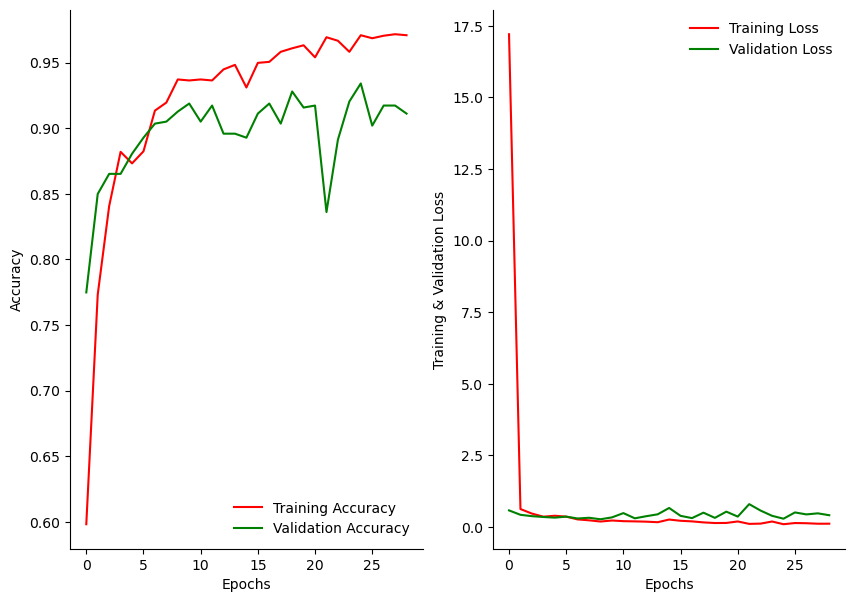

In [40]:
plot_history_acc_loss(history)

In [41]:
evaluate = model_2.evaluate(X_test, y_test)
print('Testing accuracy : {}'.format(evaluate[1])) 
print('Testing loss: {}'.format(evaluate[0]))

21/21 [==============================] - 2s 62ms/step - loss: 0.4083 - accuracy: 0.9112
Testing accuracy : 0.9111791849136353
Testing loss: 0.4083053469657898


In [42]:
test_predictions = model_2.predict(X_test)
pred = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, pred))

21/21 [==============================] - 2s 73ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       181
           1       0.85      0.91      0.88       200
           2       0.98      0.92      0.95        95
           3       0.96      0.93      0.95       177

    accuracy                           0.91       653
   macro avg       0.92      0.91      0.92       653
weighted avg       0.91      0.91      0.91       653



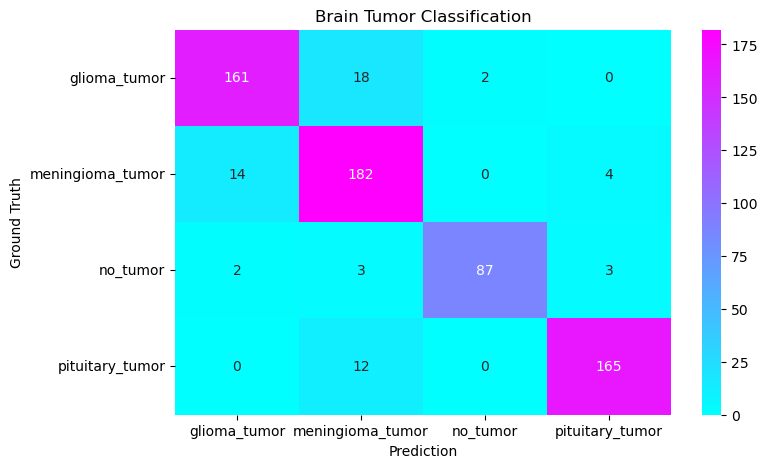

In [43]:
cm = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,5))
ax = sns.heatmap(cm, cmap='cool', annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes)
plt.title('Brain Tumor Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

    With two hidden layers, the model shows results above 85%.
    training - 97%, test - 91%. there is overfitting. 
    meningioma_tumor - 85% precision,  88% f1-score, 
    glioma_tumor - 89% recall.

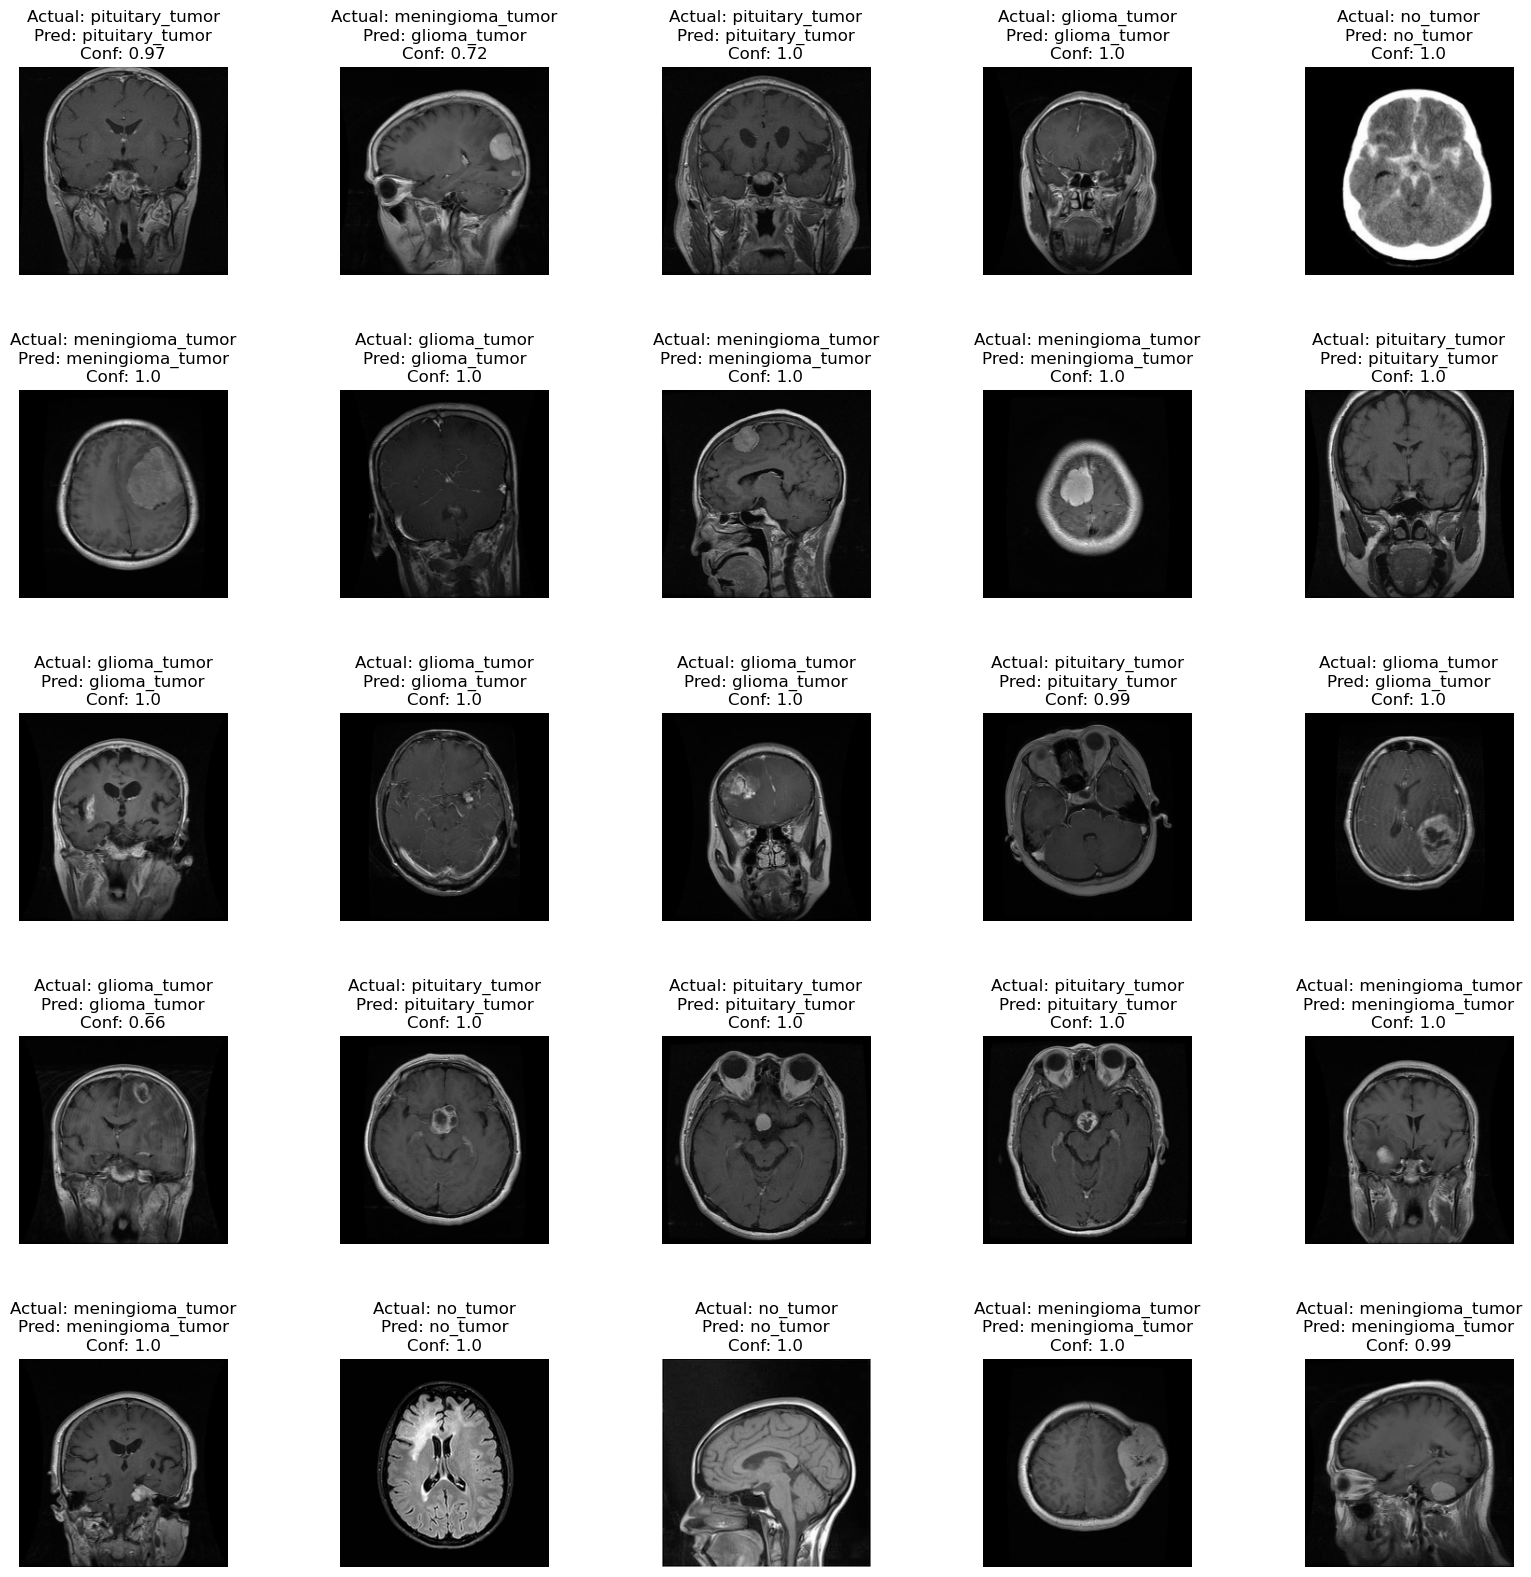

In [44]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = pred[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+classes[actual]+'\nPred: '+classes[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)  

     Also, the VGG16 model with two layers gives an error for glioma and meningioma. 

### Three hidden layer

In [45]:
base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

In [46]:
model_vgg16 = base_model.output
model_vgg16 = MaxPooling2D()(model_vgg16)
model_vgg16 = Dropout(0.3)(model_vgg16)
model_vgg16 = Flatten(name = 'flatten')(model_vgg16)
model_vgg16 = Dense(512, activation = 'relu')(model_vgg16)
model_vgg16 = Dense(4096, activation = 'relu')(model_vgg16)
model_vgg16 = Dropout(0.3)(model_vgg16)
model_vgg16 = Dense(1000, activation = 'relu')(model_vgg16)
model_vgg16 = Dropout(0.3)(model_vgg16)
model_vgg16 = Dense(4, activation = 'softmax')(model_vgg16)


model_2 = Model(inputs = base_model.input, outputs = model_vgg16)

In [47]:
model_2.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-3), metrics= ['accuracy'])

In [48]:
history = model_2.fit(X_train, y_train,
    epochs = 50, 
    validation_data = (X_test, y_test), 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/50
81/82 [============================>.] - ETA: 0s - loss: 4.2554 - accuracy: 0.5741
Epoch 1: val_loss did not improve from 0.26324
82/82 [==============================] - 7s 84ms/step - loss: 4.2324 - accuracy: 0.5741 - val_loss: 0.6432 - val_accuracy: 0.7534
Epoch 2/50
81/82 [============================>.] - ETA: 0s - loss: 0.5900 - accuracy: 0.7797
Epoch 2: val_loss did not improve from 0.26324
82/82 [==============================] - 7s 81ms/step - loss: 0.5880 - accuracy: 0.7802 - val_loss: 0.4377 - val_accuracy: 0.8331
Epoch 3/50
82/82 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.8598
Epoch 3: val_loss did not improve from 0.26324
82/82 [==============================] - 7s 82ms/step - loss: 0.4041 - accuracy: 0.8598 - val_loss: 0.3273 - val_accuracy: 0.8913
Epoch 4/50
81/82 [============================>.] - ETA: 0s - loss: 0.2869 - accuracy: 0.8970
Epoch 4: val_loss did not improve from 0.26324
82/82 [==============================] - 7s 82

C:\Users\User\AppData\Local\Temp\ipykernel_2380\178661625.py:29: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



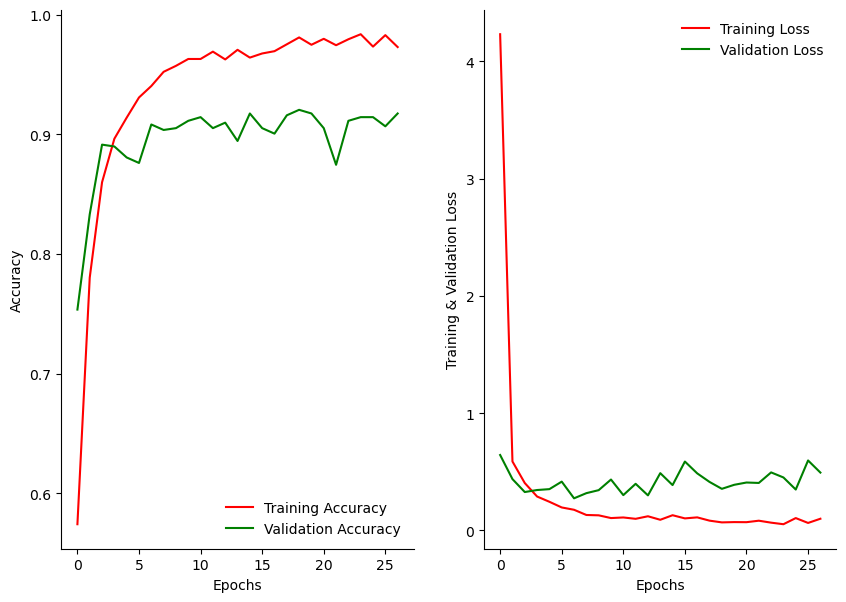

In [49]:
plot_history_acc_loss(history)

In [50]:
evaluate = model_2.evaluate(X_test, y_test)
print('Testing accuracy : {}'.format(evaluate[1])) 
print('Testing loss: {}'.format(evaluate[0]))

21/21 [==============================] - 1s 62ms/step - loss: 0.4934 - accuracy: 0.9173
Testing accuracy : 0.9173047542572021
Testing loss: 0.4933648705482483


In [51]:
test_predictions = model_2.predict(X_test)
pred = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, pred))

21/21 [==============================] - 1s 62ms/step
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       181
           1       0.87      0.90      0.88       200
           2       0.99      0.89      0.94        95
           3       0.91      0.98      0.95       177

    accuracy                           0.92       653
   macro avg       0.93      0.92      0.92       653
weighted avg       0.92      0.92      0.92       653



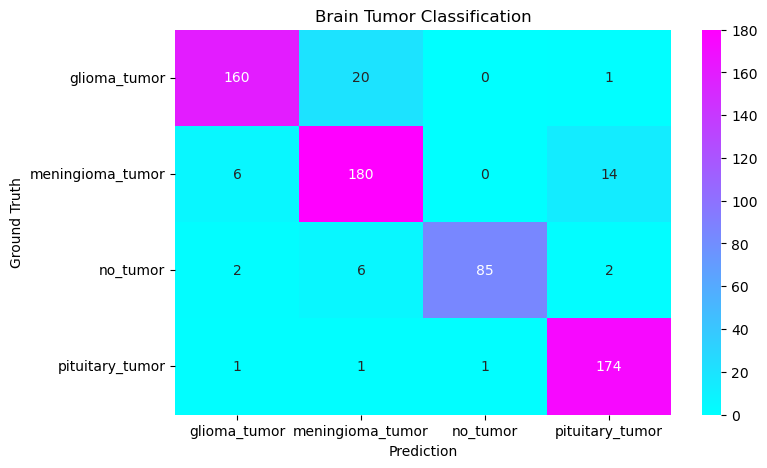

In [52]:
cm = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,5))
ax = sns.heatmap(cm, cmap='cool', annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes)
plt.title('Brain Tumor Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

    With three hidden layers, the model shows results above 87%.
    training - 97%, test - 92%. there is overfitting. 
    meningioma_tumor - 87% precision,  88% f1-score, 
    glioma_tumor - 88% recall.
    no_tumor - 89% recall

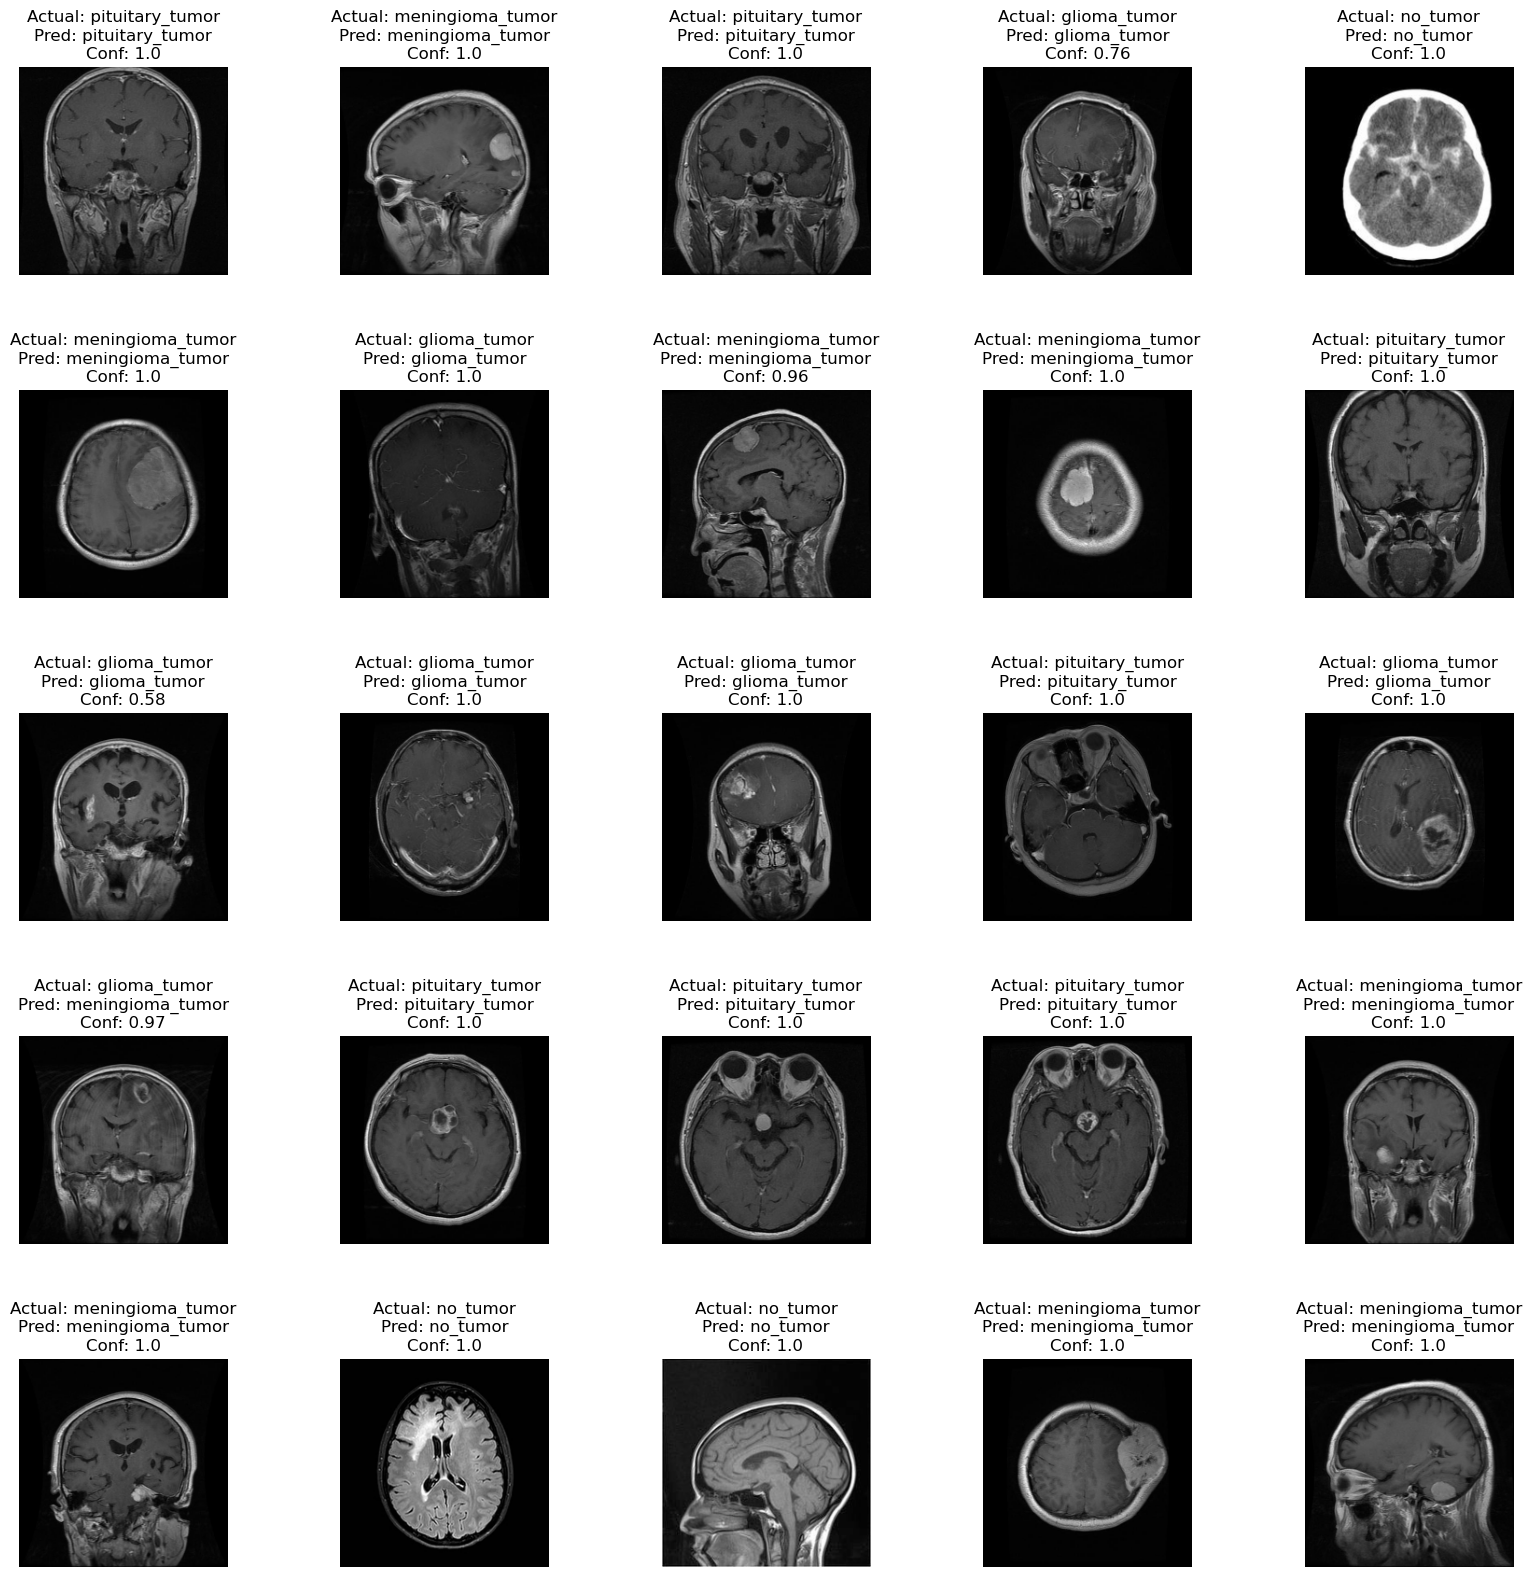

In [54]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = pred[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+classes[actual]+'\nPred: '+classes[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)  

     it also shows an error for glioma and meningioma

### Conclusion:

    Working with the Architecture of model VGG16 , I use all 16 layers and choose the optimal hyperparameters. 

    The VGG16 model shows stable and moderate results above 85%: 
    But it gives an error for glioma and meningioma in all cases. 

    The best and stable results are shown by the model with one layer. 